In [3]:
# import required libraries
import os
import torch
import numpy as np
import torch.nn as nn
from time import time
from torch import nn, optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import models, datasets, transforms
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.metrics import recall_score, precision_score, f1_score
import torchvision
from sklearn.cluster import KMeans

In [4]:
# Looking for device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# Load MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

cpu


100%|██████████| 9912422/9912422 [00:02<00:00, 3709213.62it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 21523755.12it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 6905229.72it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 22074772.62it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [5]:
train_data = datasets.MNIST(root='data', train=True, transform=transforms.ToTensor())
X_train = train_data.data.reshape(-1, 784).double().to(device) / 255.0

# Cluster the data using KMeans with k=100
kmeans = KMeans(n_clusters=100)
kmeans.fit(X_train.cpu().numpy())

# find the cluster centers
clusters = kmeans.cluster_centers_.astype(float)
print(clusters.shape)

/lustre/grp/gyqlab/lism/.conda/envs/hug/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


(100, 784)


In [6]:
# make RBF network
class RBFnet(nn.Module):
    def __init__(self, clusters):
        super(RBFnet, self).__init__()
        # remember how many centers we have
        self.N = clusters.shape[0]
        # our mean and sigmas for the RBF layer
        self.sigs = nn.Parameter( torch.ones(self.N,dtype=torch.float64)*5, requires_grad=False ) # our sigmas
        self.mus = nn.Parameter( torch.from_numpy(clusters), requires_grad=False ) # our means
        
        self.linear = nn.Linear(self.N, 10, dtype=torch.float64)

    def forward(self, x):
        distances = torch.sqrt(((x.unsqueeze(1) - self.mus)**2).sum(dim=2))
        # Calculate the Gaussian activations
        res = torch.exp((-0.5) * (distances**2) / self.sigs**2)
        # Set any NaN values to 0 (in case self.sigs is zero)
        res[res != res] = 0.0
        
        out = self.linear(res)
        return out

In [11]:
# define training function 
def train(model, train_loader, optimizer, criterion):
    model.train()
    running_loss = 0
    correct = 0
    total = 0

    for i, (images, labels) in enumerate(train_loader):
        images = images.view(-1, 784)
        images = images.to(device)
        labels = labels.to(device)


        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Loss and accuracy
        running_loss += loss.item()
        y_actual = labels.data.cpu().numpy()
        _, y_pred = torch.max(outputs, dim=1)
        correct += torch.sum(y_pred == labels).item()
        total += labels.size(0)
    
    train_acc = 100 * (correct/total)
    train_loss = running_loss / len(train_loader)

    return train_acc, train_loss

In [8]:
# define testing function
def test(model, test_loader, optimizer, criterion):
    model.eval()
    true_y = []
    predicted_y = []

    batch_loss = 0
    total_t = 0
    correct_t = 0

    with torch.no_grad():
        for i, (images_t, labels_t) in enumerate(test_loader):
            images_t = images_t.view(-1, 784)
            images_t = images_t.to(device)
            labels_t = labels_t.to(device)

            # Forward pass
            outputs_t = model(images_t)
            loss_t = criterion(outputs_t, labels_t)

            # Loss and accuracy
            batch_loss += loss_t.item()
            import pdb;pdb.set_trace()
            y_actual = labels_t.data.cpu().numpy()
            _, y_pred_t = torch.max(outputs_t, dim=1)
            correct_t += torch.sum(y_pred_t == labels_t).item()
            total_t += labels_t.size(0)
            true_y.extend(y_actual)
            predicted_y.extend(y_pred_t.cpu().numpy())
        
        test_acc = (100 * correct_t / total_t)
        test_loss = (batch_loss / len(test_loader))

    return test_acc, test_loss, true_y, predicted_y

In [9]:
model = RBFnet(clusters).to(device)

# criteria function
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [12]:
val_loss_list = []
val_acc_list = []
train_loss_list = []
train_acc_list = []

recall_scores = []
precision_scores = []
f1_scores = []

num_epochs = 20
for epoch in range(num_epochs):
    train_acc, train_loss = train(model, train_loader, optimizer, criterion)
    train_acc_list.append(train_acc)
    train_loss_list.append(train_loss)
    val_acc, val_loss, true_y, predicted_y = test(model, test_loader, optimizer, criterion)
    val_acc_list.append(val_acc)
    val_loss_list.append(val_loss)
    print('Epoch [{}/{}], Train Loss: {:.4f}, Train Acc: {:.2f}, Test Loss: {:.4f}, Test Acc: {:.2f}%'.format(
        epoch+1, num_epochs, train_loss, train_acc, val_loss, val_acc))
    recall = recall_score(true_y, predicted_y, average='micro')
    precision = precision_score(true_y, predicted_y, average='micro')
    f1 = f1_score(true_y, predicted_y, average='micro')
    recall_scores.append(recall)
    precision_scores.append(precision)
    f1_scores.append(f1)

labels: torch.Size([32])
labels: torch.Size([32])
labels: torch.Size([32])
labels: torch.Size([32])
labels: torch.Size([32])
labels: torch.Size([32])
labels: torch.Size([32])
labels: torch.Size([32])
labels: torch.Size([32])
labels: torch.Size([32])
labels: torch.Size([32])
labels: torch.Size([32])
labels: torch.Size([32])
labels: torch.Size([32])
labels: torch.Size([32])
labels: torch.Size([32])
labels: torch.Size([32])
labels: torch.Size([32])
labels: torch.Size([32])
labels: torch.Size([32])
labels: torch.Size([32])
labels: torch.Size([32])
labels: torch.Size([32])
labels: torch.Size([32])
labels: torch.Size([32])
labels: torch.Size([32])
labels: torch.Size([32])
labels: torch.Size([32])
labels: torch.Size([32])
labels: torch.Size([32])
labels: torch.Size([32])
labels: torch.Size([32])
labels: torch.Size([32])
labels: torch.Size([32])


labels: torch.Size([32])
labels: torch.Size([32])
labels: torch.Size([32])
labels: torch.Size([32])
labels: torch.Size([32])
labels: torch.Size([32])
labels: torch.Size([32])
labels: torch.Size([32])
labels: torch.Size([32])
labels: torch.Size([32])
labels: torch.Size([32])
labels: torch.Size([32])
labels: torch.Size([32])
labels: torch.Size([32])
labels: torch.Size([32])
labels: torch.Size([32])
labels: torch.Size([32])
labels: torch.Size([32])
labels: torch.Size([32])
labels: torch.Size([32])
labels: torch.Size([32])
labels: torch.Size([32])
labels: torch.Size([32])
labels: torch.Size([32])
labels: torch.Size([32])
labels: torch.Size([32])
labels: torch.Size([32])
labels: torch.Size([32])
labels: torch.Size([32])
labels: torch.Size([32])
labels: torch.Size([32])
labels: torch.Size([32])
labels: torch.Size([32])
labels: torch.Size([32])
labels: torch.Size([32])
labels: torch.Size([32])
labels: torch.Size([32])
labels: torch.Size([32])
labels: torch.Size([32])
labels: torch.Size([32])


KeyboardInterrupt: 

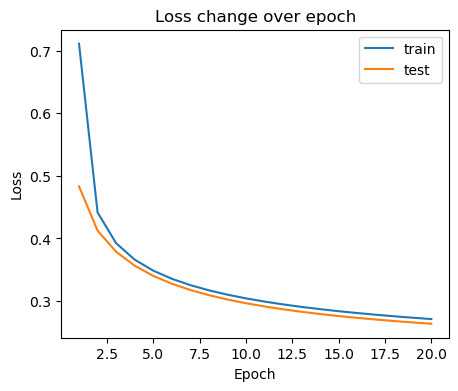

In [12]:
# plot the loss graph
epochs = list(range(1,21))
plt.figure(figsize=(5, 4))
plt.plot(epochs, train_loss_list, label="train")
plt.plot(epochs, val_loss_list, label="test")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss change over epoch")
plt.legend()
plt.show()

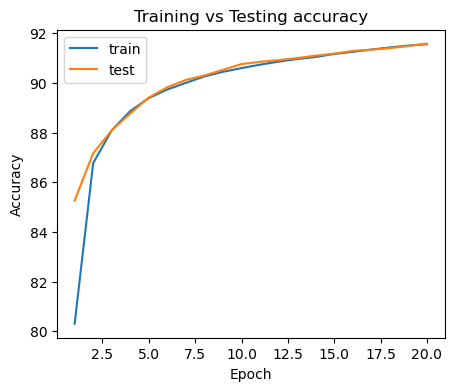

In [14]:
# plot the accuracy graph
epochs = list(range(1,21))
plt.figure(figsize=(5, 4))
plt.plot(epochs, train_acc_list, label="train")
plt.plot(epochs, val_acc_list, label="test")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Testing accuracy")
plt.legend()
plt.show()

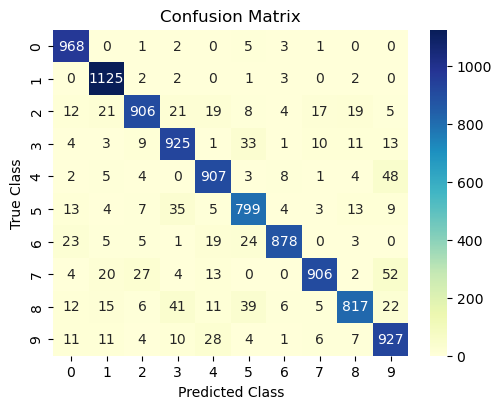

In [15]:
# constant for classes
classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')
cf_matrix = confusion_matrix(true_y, predicted_y)

dataframe = pd.DataFrame(cf_matrix, index=classes, columns=classes)
plt.figure(figsize=(5, 4))
 
# Create heatmap
sns.heatmap(dataframe, annot=True, cmap="YlGnBu",fmt="d")
 
plt.title("Confusion Matrix"), plt.tight_layout()
 
plt.ylabel("True Class"), 
plt.xlabel("Predicted Class")
plt.show()

In [16]:
print(classification_report(true_y, predicted_y, target_names=classes))

              precision    recall  f1-score   support

           0       0.92      0.99      0.95       980
           1       0.93      0.99      0.96      1135
           2       0.93      0.88      0.90      1032
           3       0.89      0.92      0.90      1010
           4       0.90      0.92      0.91       982
           5       0.87      0.90      0.88       892
           6       0.97      0.92      0.94       958
           7       0.95      0.88      0.92      1028
           8       0.93      0.84      0.88       974
           9       0.86      0.92      0.89      1009

    accuracy                           0.92     10000
   macro avg       0.92      0.91      0.91     10000
weighted avg       0.92      0.92      0.92     10000

